# Zadanie

Używająć narzędzi do analityki, pomóc zespołowi marketingowemu zwiększyć wydajność kampanii reklamowej lokaty terminowej.

# Analiza danych z poprzedniej kampanii

Do przejrzenia rozkładu danych został wygenerowany raport z wizualizacjami. Na podstawie wykresów wyciągnięto następujące wnioski:

1. Zestawy danych dla grupy z kampanią oraz dla grupy kontrolnej są podobnie rozłożone
2. Najwięcej lokat terminowych wzięły grupy pracujące w zawodach administracyjnych, pracownicy fizyczni i technicy. Ponadto, lokaty najczęściej są brane wśród ludzi będących w związku małżeńskim. Jeżeli rozpatrywana jest edukacja, to najwięcej pozytywnego przyjęcia warunków lokaty można się spodziewać wśród grup społecznych ze skończoną szkołą średnią lub z wyższym wykształceniem.
3. Posiadane pożyczki lub kredyty nie wpływają na % przyjęcia lokaty terminowej.
4. Bardziej skutecznym kanałem kontaktu do klienta jest "cellular"
5. Najbardziej aktywnym marketingowo miesiącem był maj, lub szerzej, 2 i 3 kwartał. Te miesiące mają również najmniejszy % przyjęcia lokaty

Dalsza analiza została przeprowadzona w notebooku poniżej

### Wstępna analiza z wykorzystaniem narzędzi Pythona wraz z oczyszczeniem danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.model_selection import learning_curve
import plotly.graph_objs as go
import time

pd.options.display.max_columns = 54
rs = 1111

In [2]:
#import danych
df = pd.read_csv('bank_data_prediction_task.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

C:\Users\Olek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,test_control_flag
0,37,services,married,high.school,no,yes,no,telephone,may,mon,226.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
1,56,services,married,high.school,no,no,yes,telephone,may,mon,307.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
2,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,campaign group
3,25,services,single,high.school,no,yes,no,telephone,may,mon,50.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
4,25,services,single,high.school,no,yes,no,telephone,may,mon,222.0,1.0,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,campaign group


__Zaimportowany plik CSV składa się z kolumn numerycznych jak i kategorialnych__

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   job                41188 non-null  object 
 2   marital            41188 non-null  object 
 3   education          41188 non-null  object 
 4   default            41188 non-null  object 
 5   housing            41188 non-null  object 
 6   loan               41188 non-null  object 
 7   contact            16476 non-null  object 
 8   month              16476 non-null  object 
 9   day_of_week        16476 non-null  object 
 10  duration           16476 non-null  float64
 11  campaign           16476 non-null  float64
 12  pdays              41188 non-null  int64  
 13  previous           41188 non-null  int64  
 14  poutcome           41188 non-null  object 
 15  emp.var.rate       41188 non-null  float64
 16  cons.price.idx     409

__Kolumny 7-11 dotyczą tylko grupy klientów którzy zostali wybrani do kampanii marketingowej, dlatego jest ich mniej. Inna ilość w kolumnie 16 sugeruje, że są w niej brakujące wartości.__

In [4]:
# sprawdzenie rozmiaru dwóch grup
df['test_control_flag'].value_counts()

control group     24712
campaign group    16476
Name: test_control_flag, dtype: int64

In [5]:
# zamiana z 999 na 0 jeśli nie było kontaktu
df.pdays = df.pdays.replace(999, 0)

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,16476.000000,16476.000000,41188.000000,41188.000000,41188.000000,40938.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,259.660172,2.546856,0.221229,0.172963,0.081886,93.575950,-40.502600,3.621291,5167.035911
std,10.42125,260.660561,2.699664,1.348874,0.494901,1.570960,0.578889,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,103.000000,1.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,321.000000,3.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,43.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


__Spośród obliczonych miar powyżej, warto zwrócić uwagę na rzędy oznaczone jako "mean", "min", "max". Widać, że średnia wieku klientów wynosi około 40 lat ale wartości rozciągają się od 17 do 98 lat. Taka analiza pozwoli lepiej wycelować kampanie reklamową.__

In [7]:
# rozdzielenie grup na osobne dataframy
campaign = df[df['test_control_flag']=='campaign group']
campaign = campaign.drop(['test_control_flag'], axis=1)
campaign.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16476 entries, 0 to 16475
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16476 non-null  int64  
 1   job             16476 non-null  object 
 2   marital         16476 non-null  object 
 3   education       16476 non-null  object 
 4   default         16476 non-null  object 
 5   housing         16476 non-null  object 
 6   loan            16476 non-null  object 
 7   contact         16476 non-null  object 
 8   month           16476 non-null  object 
 9   day_of_week     16476 non-null  object 
 10  duration        16476 non-null  float64
 11  campaign        16476 non-null  float64
 12  pdays           16476 non-null  int64  
 13  previous        16476 non-null  int64  
 14  poutcome        16476 non-null  object 
 15  emp.var.rate    16476 non-null  float64
 16  cons.price.idx  16476 non-null  float64
 17  cons.conf.idx   16476 non-null 

In [8]:
control = df[df['test_control_flag']=='control group']
control = control.drop(['contact', 'month', 'day_of_week', 'duration', 'campaign', 'test_control_flag'], axis=1)
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24712 entries, 16476 to 41187
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24712 non-null  int64  
 1   job             24712 non-null  object 
 2   marital         24712 non-null  object 
 3   education       24712 non-null  object 
 4   default         24712 non-null  object 
 5   housing         24712 non-null  object 
 6   loan            24712 non-null  object 
 7   pdays           24712 non-null  int64  
 8   previous        24712 non-null  int64  
 9   poutcome        24712 non-null  object 
 10  emp.var.rate    24712 non-null  float64
 11  cons.price.idx  24462 non-null  float64
 12  cons.conf.idx   24712 non-null  float64
 13  euribor3m       24712 non-null  float64
 14  nr.employed     24712 non-null  float64
 15  y               24712 non-null  object 
dtypes: float64(5), int64(3), object(8)
memory usage: 3.2+ MB


In [9]:
control['cons.price.idx'].isna().sum()

250

In [10]:
control['cons.price.idx'] = control['cons.price.idx'].fillna(control['cons.price.idx'].median())

__Puste wartości w kolumnie cons.price.idx zostały zamienione na medianę wartości z tej kolumny__

In [11]:
cat_campaign = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'poutcome']
num_campaign = ['age', 'duration','campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_control = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
num_control = ['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [12]:
campaign.y = campaign.y.map({'no':0, 'yes':1}).astype('uint8')
control.y = control.y.map({'no':0, 'yes':1}).astype('uint8')

In [13]:
corr_campaign = campaign.corr()
corr_campaign.style.background_gradient(cmap='PuBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.008232,0.005783,0.012055,0.021171,-0.004366,0.001993,0.123604,0.005564,-0.023151,0.002539
duration,-0.008232,1.000000,-0.071148,0.056087,0.024800,-0.030369,0.004365,-0.008762,-0.034266,-0.044800,0.316615
campaign,0.005783,-0.071148,1.000000,-0.040603,-0.081997,0.155813,0.126374,-0.009443,0.140409,0.149396,-0.052679
pdays,0.012055,0.056087,-0.040603,1.000000,0.482783,-0.220103,-0.039693,0.070532,-0.251317,-0.325838,0.192994
previous,0.021171,0.024800,-0.081997,0.482783,1.000000,-0.424115,-0.204479,-0.051007,-0.456336,-0.504284,0.175909
emp.var.rate,-0.004366,-0.030369,0.155813,-0.220103,-0.424115,1.000000,0.776506,0.200240,0.972579,0.907313,-0.206111
cons.price.idx,0.001993,0.004365,0.126374,-0.039693,-0.204479,0.776506,1.000000,0.065784,0.689884,0.522841,-0.086526
cons.conf.idx,0.123604,-0.008762,-0.009443,0.070532,-0.051007,0.200240,0.065784,1.000000,0.281342,0.103376,0.029122
euribor3m,0.005564,-0.034266,0.140409,-0.251317,-0.456336,0.972579,0.689884,0.281342,1.000000,0.945145,-0.217425
nr.employed,-0.023151,-0.044800,0.149396,-0.325838,-0.504284,0.907313,0.522841,0.103376,0.945145,1.000000,-0.251161


__Patrząc na kolumnę "y", która zawiera informację o przyjęciu lokaty można zauważyć, że największą wartość długość kontaktu z klientem (przecięcie rzędu "duratrion" i kolumny "y" lub odwrotnie).
Wartości z kolumn numerycznych należy ustandaryzować by ujednolicić ich wpływ.__

In [14]:
corr_control = control.corr()
corr_control.style.background_gradient(cmap='PuBu')

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.022239,0.026495,0.002312,-0.001541,0.133251,0.014269,-0.014081,0.029915
pdays,0.022239,1.000000,0.486787,-0.218168,-0.041932,0.059939,-0.252162,-0.321310,0.268220
previous,0.026495,0.486787,1.000000,-0.418108,-0.199978,-0.050896,-0.453293,-0.499399,0.229594
emp.var.rate,0.002312,-0.218168,-0.418108,1.000000,0.769877,0.193225,0.972022,0.906741,-0.295227
cons.price.idx,-0.001541,-0.041932,-0.199978,0.769877,1.000000,0.054142,0.683052,0.518326,-0.130399
cons.conf.idx,0.133251,0.059939,-0.050896,0.193225,0.054142,1.000000,0.275224,0.098589,0.056350
euribor3m,0.014269,-0.252162,-0.453293,0.972022,0.683052,0.275224,1.000000,0.945162,-0.303582
nr.employed,-0.014081,-0.321310,-0.499399,0.906741,0.518326,0.098589,0.945162,1.000000,-0.351305
y,0.029915,0.268220,0.229594,-0.295227,-0.130399,0.056350,-0.303582,-0.351305,1.000000


### Przygotowanie danych do klasyfikacji

In [15]:
# zastosowanie hot one encoding na kolumnach kategorialnych
campaign = pd.get_dummies(data=campaign, columns=cat_campaign, drop_first=True)
control = pd.get_dummies(data=control, columns=cat_control, drop_first=True)

In [16]:
# standaryzacja kolumn numerycznych 
campaign_scaler = StandardScaler()
num_campaign_scaled = campaign_scaler.fit_transform(campaign[num_campaign])
num_campaign_scaled = pd.DataFrame(num_campaign_scaled, columns=num_campaign)

control_scaler = StandardScaler()
num_control_scaled = control_scaler.fit_transform(control[num_control])
num_control_scaled = pd.DataFrame(num_control_scaled, columns=num_control)

In [17]:
campaign = campaign.drop(num_campaign, axis=1)
control = control.drop(num_control, axis=1)

In [18]:
campaign_transformed = num_campaign_scaled.join(campaign)
control.reset_index(inplace=True)
control_transformed = num_control_scaled.join(control)

In [19]:
# podział dataframa z danymi z grupy z kampanią na zestaw treningowy i testowy
y_campaign = campaign_transformed.y
X_campaign = campaign_transformed.drop('y', axis=1)

X_train_campaign, X_test_campaign, y_train_campaign, y_test_campaign = train_test_split(X_campaign, y_campaign, random_state=rs, test_size=0.2, stratify=y_campaign)

__Do przeprowadzenia klasyfikacji zostały wybrane modele wypisane w słowniku poniżej__

In [20]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(random_state=rs, max_iter=1500, n_jobs=-1),
    "Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Linear SVM": SVC(random_state=rs, probability=True),
    "SGDClassifier":  SGDClassifier(random_state=rs, max_iter=1500),
    "Decision Tree": DecisionTreeClassifier(random_state=rs),
    "Random Forest": RandomForestClassifier(n_estimators=18, random_state=rs, n_jobs=-1),
    "Neural Net": MLPClassifier(alpha=1, random_state=rs),
    "Naive Bayes": GaussianNB()
}

In [21]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, X_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

df_results = batch_classify(X_train_campaign, y_train_campaign, X_test_campaign)
print(df_results.sort_values(by='train_score', ascending=False))

trained Logistic Regression in 0.05 s
trained Nearest Neighbors in 1.75 s
trained Linear SVM in 24.86 s
trained SGDClassifier in 0.08 s
trained Decision Tree in 0.62 s
trained Random Forest in 1.03 s
trained Neural Net in 28.25 s
trained Naive Bayes in 0.12 s
            classifier  train_score  training_time
4        Decision Tree     0.999924       0.625000
5        Random Forest     0.994006       1.031250
1    Nearest Neighbors     0.883612       1.750000
2           Linear SVM     0.877921      24.859375
6           Neural Net     0.867754      28.250000
0  Logistic Regression     0.866540       0.046875
3        SGDClassifier     0.856829       0.078125
7          Naive Bayes     0.746131       0.125000


In [22]:
#sprawdzenie wyników dt
train_score_dt = dict_classifiers['Decision Tree'].score(X_train_campaign, y_train_campaign)
test_score_dt = dict_classifiers['Decision Tree'].score(X_test_campaign, y_test_campaign)
print(train_score_dt, test_score_dt)

0.9999241274658573 0.806128640776699


In [23]:
#sprawdzenie wyników rf
train_score_rf = dict_classifiers['Random Forest'].score(X_train_campaign, y_train_campaign)
test_score_rf = dict_classifiers['Random Forest'].score(X_test_campaign, y_test_campaign)
print(train_score_rf, test_score_rf)

0.9940060698027314 0.8658980582524272


__Bardzo wysokie wartości wstępnego treningu dla modeli drzewa decyzyjnego i lasu losowego świadczą o tym, że algorytmy wpadły w przeuczenie. Potwierdza to, że oba modele wykazują dużą różnicę w wyniku precyzyjności pomiędzy zbiorem trenującym a testowym. Należy przeprowadzić strojenie parametrów by uniknąć niechcianego zjawiska.__

#### Strojenie parametrów

In [24]:
from sklearn.model_selection import RandomizedSearchCV

param_dt = {'max_depth': [4, 6, 8, 12, 16, 24], 'max_features': [4, 6, 8, 12, 16, 24], 'min_samples_split': [4, 8, 16, 24]}
rs_dt = RandomizedSearchCV(estimator=dict_classifiers['Decision Tree'], param_distributions=param_dt, n_iter=5, cv=5, scoring='accuracy')

param_rf = {'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rs_rf = RandomizedSearchCV(estimator=dict_classifiers['Random Forest'], param_distributions=param_rf, n_iter=10, cv=5, scoring='accuracy')

param_knn = {'n_neighbors': np.arange(1, 22)}
rs_knn = RandomizedSearchCV(estimator=dict_classifiers['Nearest Neighbors'], param_distributions=param_knn, n_iter=10, cv=5, scoring='accuracy')

param_svc = {'C': [1, 10], 'gamma': [0.1,0.01],'kernel': ['rbf', 'sigmoid']}
rs_svc = RandomizedSearchCV(estimator=dict_classifiers['Linear SVM'], param_distributions=param_svc, n_iter=10, cv=5, scoring='accuracy')

param_mlp = {'activation': ['relu', 'tanh', 'logistic', 'identity'], 'solver': ['adam', 'lbfgs', 'sgd'], 'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
             'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': [2000, 2500, 3000, 4000]}
rs_mlp = RandomizedSearchCV(estimator=dict_classifiers['Neural Net'], param_distributions=param_mlp, n_iter=10, cv=5, scoring='accuracy')

param_lr = {'C': [0.3, 0.6, 0.7], 'solver': ['sag', 'lbfgs']}
rs_lr = RandomizedSearchCV(estimator=dict_classifiers['Logistic Regression'], param_distributions=param_lr, n_iter=10, cv=5, scoring='accuracy')

param_sgd = {'loss': ['log', 'huber', 'hinge'], 'learning_rate': ['optimal', 'adaptive'], 'eta0': [0.001, 0.01, 0.1], 'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.1, 1, 5, 10]}
rs_sgd = RandomizedSearchCV(estimator=dict_classifiers['SGDClassifier'], param_distributions=param_sgd, n_iter=10, cv=5, scoring='accuracy')

params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
rs_nb = RandomizedSearchCV(estimator=dict_classifiers['Naive Bayes'], param_distributions=params_nb, n_iter=10, cv=5, scoring='accuracy')

__Do wyboru najlepszych parametrów każdego z modeli została wybrana funkcja RandomizedSearchCV ponieważ, jest szybsza niż GridSearch a daje zbliżone wyniki__

In [25]:
results = [rs_lr,
           rs_knn, 
           rs_svc, 
           rs_sgd, 
           rs_dt, 
           rs_rf,
           rs_mlp,
           rs_nb]
acc = {}
roc = {}
models = []

for index, model in enumerate(results):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(list(dict_classifiers.keys())[index]))
        model.fit(X_train_campaign, y_train_campaign)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test_campaign, model.predict_proba(X_test_campaign)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test_campaign, y_test_campaign)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        acc[index] = model.best_score_
        roc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic Regression


C:\Users\Olek\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.



---------------------------------------------
best params {'solver': 'sag', 'C': 0.3}
best score is 0.8655538694992412
---------------------------------------------
ROC_AUC is 0.8092894631094895 and accuracy rate is 0.8692354368932039
It lasted for 22.017 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Nearest Neighbors
---------------------------------------------
best params {'n_neighbors': 21}
best score is 0.8585735963581183
---------------------------------------------
ROC_AUC is 0.776794744889487 and accuracy rate is 0.866504854368932
It lasted for 21.065 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Linear SVM


C:\Users\Olek\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



---------------------------------------------
best params {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
best score is 0.8615326251896814
---------------------------------------------
ROC_AUC is 0.7476419790626574 and accuracy rate is 0.868628640776699
It lasted for 599.069 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is SGDClassifier
---------------------------------------------
best params {'penalty': 'l2', 'loss': 'log', 'learning_rate': 'adaptive', 'eta0': 0.01, 'alpha': 0.1}
best score is 0.8553869499241274
---------------------------------------------
ROC_AUC is 0.7937708422740803 and accuracy rate is 0.8567961165048543
It lasted for 2.007 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Decision Tree
---------------------------------------------
best params {'min_samples_split': 4, 'max_features': 24, 'max_depth': 4}
best score is 0.8614567526555387
-------

C:\Users\Olek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\Olek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\Olek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

---------------------------------------------
best params {'solver': 'adam', 'max_iter': 4000, 'learning_rate': 'invscaling', 'alpha': 0.001, 'activation': 'identity'}
best score is 0.8653262518968134
---------------------------------------------
ROC_AUC is 0.8077618982922186 and accuracy rate is 0.8683252427184466
It lasted for 1366.584 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Naive Bayes
---------------------------------------------
best params {'var_smoothing': 0.2848035868435802}
best score is 0.84597875569044
---------------------------------------------
ROC_AUC is 0.7540196520315174 and accuracy rate is 0.850121359223301
It lasted for 0.763 sec
++++++++ End Model +++++++++++++++++++++++++++




In [26]:
acc

{0: 0.8655538694992412,
 1: 0.8585735963581183,
 2: 0.8615326251896814,
 3: 0.8553869499241274,
 4: 0.8614567526555387,
 5: 0.8663125948406677,
 6: 0.8653262518968134,
 7: 0.84597875569044}

In [27]:
roc

{0: 0.8092894631094895,
 1: 0.776794744889487,
 2: 0.7476419790626574,
 3: 0.7937708422740803,
 4: 0.7869287896007702,
 5: 0.8115890771567599,
 6: 0.8077618982922186,
 7: 0.7540196520315174}

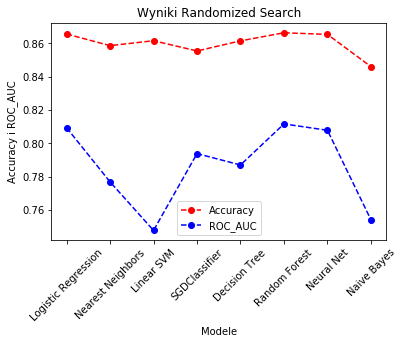

In [28]:
plt.plot(list(dict_classifiers.keys()), list(acc.values()), c='r', marker='o', linestyle='--')
plt.plot(list(dict_classifiers.keys()), list(roc.values()), c='b', marker='o', linestyle='--')
plt.xlabel('Modele')
plt.xticks(rotation=45)
plt.ylabel('Accuracy i ROC_AUC')
plt.title('Wyniki Randomized Search')
plt.legend(['Accuracy', 'ROC_AUC'])
plt.show();

In [29]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

results_df = pd.DataFrame(list(zip(list(dict_classifiers.keys()), list(acc.values()), list(roc.values()))), \
                  columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

In [30]:
s = results_df.style.apply(highlight_max, subset=['Accuracy_rate', 'Roc_auc_rate'])
s

,Model,Accuracy_rate,Roc_auc_rate
0,Logistic Regression,0.865554,0.809289
1,Nearest Neighbors,0.858574,0.776795
2,Linear SVM,0.861533,0.747642
3,SGDClassifier,0.855387,0.793771
4,Decision Tree,0.861457,0.786929
5,Random Forest,0.866313,0.811589
6,Neural Net,0.865326,0.807762
7,Naive Bayes,0.845979,0.754020


__Najlepsze wyniki precyzji i ROC AUG uzyskał las losowy. Jego parametry zostały użyte w dalszej części analizy__

In [31]:
rf = models[5]
rf.fit(X_train_campaign, y_train_campaign)
# porównanie wyników precyzji na zbiorze uczącym i testowym by sprawdzić czy nie wystąpił overfitting
train_score = rf.score(X_train_campaign, y_train_campaign)
test_score = rf.score(X_test_campaign, y_test_campaign)
print(train_score, test_score)

0.9246585735963582 0.8692354368932039


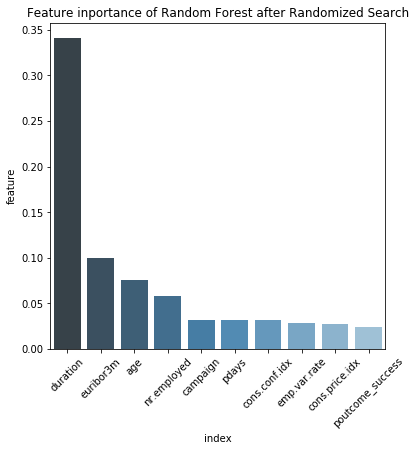

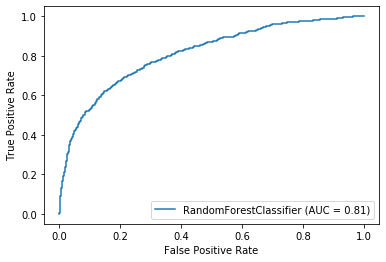

In [32]:
def build_feature_importance(models, X_train, y_train, X_test, y_test):
    data = pd.DataFrame(models.feature_importances_, X_train.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[6,6])
    sns.barplot(x='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of Random Forest after Randomized Search')
    plt.xticks(rotation=45)
    plt.show();
    plot_roc_curve(models, X_test, y_test)
    plt.show()
    
build_feature_importance(rf, X_train_campaign, y_train_campaign, X_test_campaign, y_test_campaign)

__Najbardziej znaczącą cechą dla klasyfikacji grupy kampanijnej jest czas trwania kontaktu z klientem__

In [33]:
rf_control = models[5]

y_control = control_transformed.y
X_control= control_transformed.drop(['y', 'index'], axis=1)

X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control, y_control, random_state=rs, test_size=0.2, stratify=y_control)

In [34]:
rf_control.fit(X_train_control, y_train_control)
train_score = rf_control.score(X_train_control, y_train_control)
test_score = rf_control.score(X_test_control, y_test_control)
print(train_score, test_score)

0.9298902321816986 0.8976330163868096


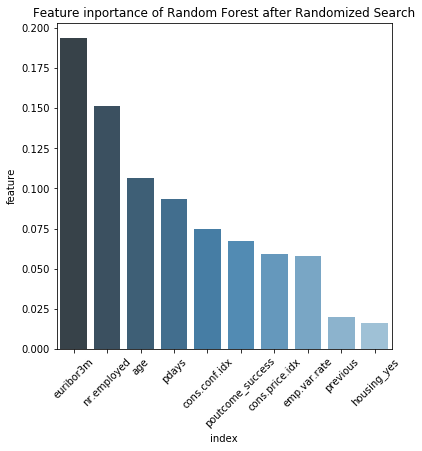

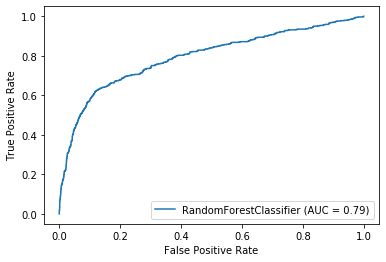

In [35]:
build_feature_importance(rf_control, X_train_control, y_train_control, X_test_control, y_test_control)

__Dla porównania ten sam wykres dla grupy kontrolnej__

# Podsumowanie

Przygotowując następną kampanie reklamową, bank powinien wziąć pod uwagę następujące wnioski:
    
1. __Czas w którym odbywa się kampania__: Aktywność marketingowa banku przypadła na głównie na przełom wiosny i lata. Jednakże, w tych miesiącach procent klientów, którzy przyjęli lokatę (~13-14%) jest niższy niż w miesiącach jesinno-zimowych, w których aktywność jest niska (średnio około 40% akceptacji). Następna kampania powinna skupić się szczególnie na grudniu, marcu, październiku i wrześniu, ponieważ w tych miesiącach największy procent klientów jest skłonna do przyjęcia lokaty.
2. __Należy ograniczyć liczbę kontaktów do klienta__: Na stworzonych wykresach widać, że ilość klientów, którzy przyjęli ofertę spada wraz z każdym kolejnym kontaktem banku. Nie powinno kontaktować się z klientem więcej niż 4 razy. Z każdym następnym kontaktem spada prawdopodobieństwo, że klient przyjmie ofertę.
3. __Targetowanie klientów__: Każda grupa wiekowa, zawodowa oraz posiadająca różne stany cywilne inaczej zainteresowana jest danym produktem. Na przykładzie analizowanych danych, największe zainteresowanie lokatą było wśród ludzi bardzo młodych oraz po 60 roku życia. Pozostałych wymienione kategorie również znacząco wpływają na decyzje klienta i powinny być brane pod uwagę przy losowaniu klientów do kampanii reklamowych w przyszłości.
4. __Przeprowadzanie ankiety dla klientów podczas rozmowy__: Czas trwania kontaktu z klientem jest najbardziej skorelowaną wartością jeśli chodzi o prawdopodobieństwo tego, czy klient przyjmie ofertę. Przeprowadzenie zajmującej dla klienta ankiety podczas rozmowy pozwoli na wydłużenie czasu kontaktu z nim i dzięki temu istnieje możliwość, że zwiększy się prawdopodobieństwo przyjęcia przez niego proponowanej lokaty z kampanii marketingowej. 

Mając na uwadze te propozycję, następna kampania reklamowa banku powinna mieć wyższą skuteczność.